## Удаление фона с помощью SVD 

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения &mdash; удаление фона из видео.
Для этого сначала загрузим видео, на котором есть движущиеся объекты и неизменный фон.

In [10]:
import moviepy.editor as mpe
video = mpe.VideoFileClip("data/SVD_video_1.mp4")
video.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Импортируем необходимые библиотеки и представим видео в виде трехмерного массива размеров `(#кадров) x (#пикселей по горизонтали) x (#пикселей по вертикали)`.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
video.fps

23.976023976023978

In [24]:
def video_to_array(video):
    duration = int(video.duration)
    nframes = int(video.fps * video.duration)
    size_h, size_w = video.size
    arr = np.zeros([nframes, size_w, size_h])
    for i in range(nframes):
        arr[i, :, :] = video.get_frame(i/nframes * duration)[:, :, 0].astype(np.float)
    print('image size: {1:} x {2:}, \nnumber of frames: {0:}'.format(nframes, size_w, size_h))
    return arr

image size: 60 x 80, 
number of frames: 2883


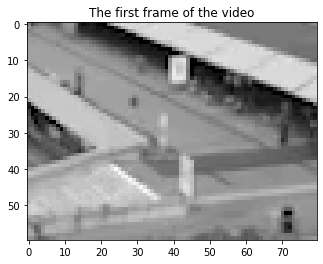

In [25]:
arr = video_to_array(video)
plt.imshow(arr[0, :, :], cmap='gray')
_ = plt.title('The first frame of the video')

### a. Применение базового алгоритма SVD

1. С помощью функции ```np.reshape(...)``` получите из трехмерного массива ```arr``` двумерный массив ```M``` размера ```nframes x (size_h * size_w)```, каждой строкой которого является изображение размера ```size_h x size_w```, представленное в виде вектора с ```size_h * size_w``` элементами.

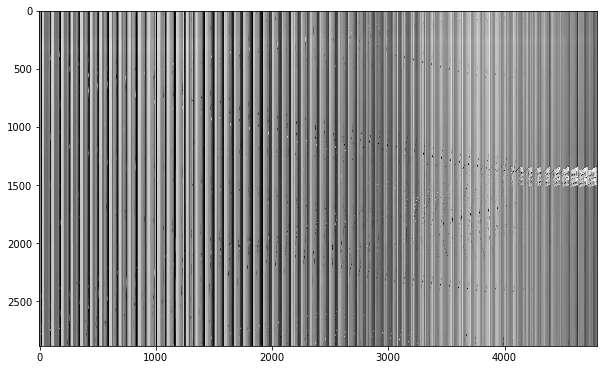

In [28]:
nframes, size_w, size_h = arr.shape
M = np.reshape(arr, (nframes, size_h * size_w))

plt.figure(figsize=(10, 10))
plt.imshow(M, cmap='gray')

2.  Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd(..., full_matrices=False)``` (параметр ```full_matrices``` отвечает за размеры матрицы $U$ и $V$ из SVD и позволяет заметно экономить место для прямоугольных матриц). Постройте график сингулярных чисел, отсортированных по убыванию и поделенных на старшее сингулярное число. Шкала с сингулярными числами должна быть логарифмической. Для этого, например, используйте функцию ```plt.semilogy```. Объясните, почему наибольшее и несколько наименьших (близких к 0) сингулярных число заметно отличается от остальных. 

**Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел.

In [29]:
U, S, Vh = np.linalg.svd(M, full_matrices=False)

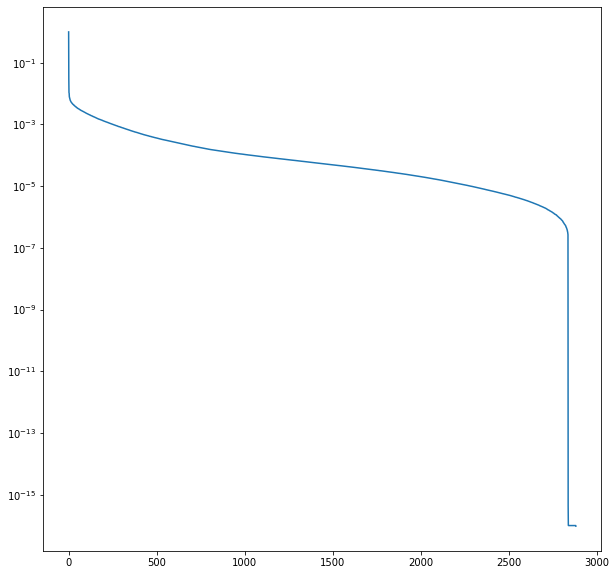

In [30]:
plt.figure(figsize=(10, 10))
plt.semilogy(np.arange(S.shape[0]),S/S[0])

Сингулярные числа связанны напрямую связанны рангом матрицы. Поскольку ранг у матрицы совсем небольшой, то ровно это же количество первых сингулярных значений будет хранить всю информацию матрицы. Последние же несколько значений настолько маленькие, что не превышают ULP, поэтому улетают по точности.

3.  Напишите функцию ```trunc_svd(M, r)```, которая считает оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга, а также **относительную** точность этого приближения в матричной 2-норме, т.е. $$
\frac{\|M - M_{r}\|_2}{\|M\|_2}.
$$
Для расчета относительной точности используйте **только** сингулярные числа матрицы $M$. 

In [31]:
def trunc_svd(M, r):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            
        Output
            Mr: 2D numpy array of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    U, S, Vh = np.linalg.svd(M, full_matrices=False)
    rel_eps = S[r+1] / S[0]
    for i in range(r+1, S.shape[0]):
        S[i] = 0
    Mr = np.dot(U, np.dot(np.diag(S),Vh))
    return Mr, rel_eps  

    raise NotImplementedError()

4. **(2 балла)** Используя написанную функцию, найдите наилучшее приближение матрицы ```M``` матрицей ```M_svd``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [32]:
M_svd, rel_eps = trunc_svd(M, 1)

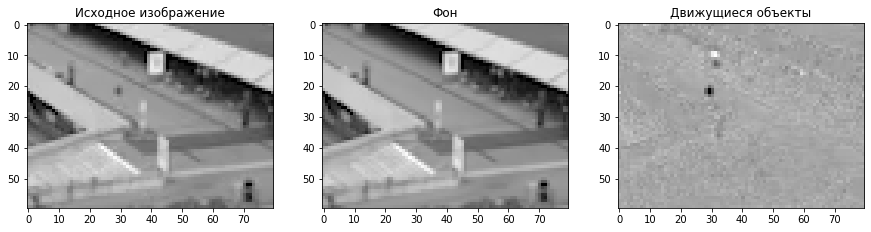

In [33]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(np.reshape(M[0], (size_w, size_h)), cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(np.reshape(M_svd[0], (size_w, size_h)), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(np.reshape(M[0] - M_svd[0], (size_w, size_h)), cmap='gray') # TO BE FILLED
_ = axs[2].set_title("Движущиеся объекты")

### b. Применение рандомизированного алгоритма SVD

Загрузим теперь видео в более высоком разрешении.

In [34]:
import moviepy.editor as mpe
video = mpe.VideoFileClip("data/SVD_video_3.mp4", target_resolution=(100, 178))
video.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


image size: 100 x 178, 
number of frames: 3600


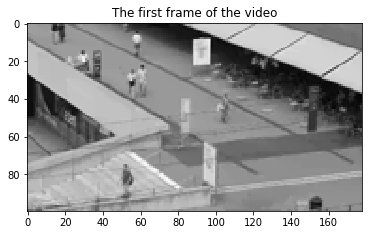

In [35]:
M = video_to_array(video)
plt.imshow(M[0, :, :], cmap='gray')
_ = plt.title('The first frame of the video')
nframes, size_w, size_h = M.shape
M = np.reshape(M, (nframes, size_h * size_w))

Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений (есть также [пост](https://gregorygundersen.com/blog/2019/01/17/randomized-svd/) с описанием алгоритма).

1.  Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм заспускается с ```r + oversampling``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы не вычисляете в явном виде матрицу $QQ^\top$. Если на заданной матрице алгоритм работает слишком долго (минуты), то возможно, вы что-то делаете не так.

In [36]:
def rand_svd(M, r, oversampling=10):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            oversampling: number of extra random vectors to approximate range(M)
    
        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    
    Sigm = np.random.normal(0, 1, (M.shape[1], r + oversampling))
    Y = np.dot(M, Sigm)
    Q,R = np.linalg.qr(Y)
    M_temp = np.dot(Q.T, M)
    
    U, S, Vh = np.linalg.svd(M_temp, full_matrices=False)
    
    rel_eps = min(r+1, S.shape[0]-1)
    
    for i in range(r+1, S.shape[0]):
        S[i] = 0
    
    Q = np.dot(Q,U)
    Mr = np.dot(Q, np.dot(np.diag(S),Vh))
    
    return Mr, rel_eps
    raise NotImplementedError()

2. **(1 балла)** Используя ```rand_svd```, найдите наилучшее приближение матрицы ```M``` матрицей ```M_rand``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

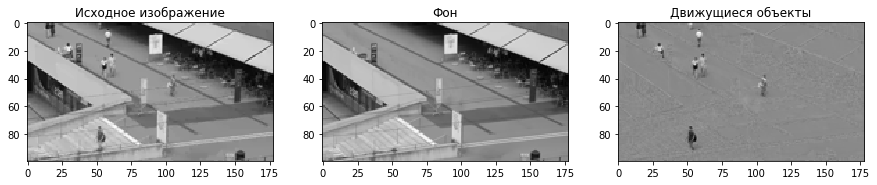

In [37]:
M_rand, rel_eps = rand_svd(M,1)

_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(np.reshape(M[0], (size_w, size_h)), cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(np.reshape(M_rand[0], (size_w, size_h)), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(np.reshape(M[0] - M_rand[0], (size_w, size_h)), cmap='gray') # TO BE FILLED
_ = axs[2].set_title("Движущиеся объекты")

3. Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M||_F}
$$
при $r=2$ в зависимости от $p$ (```oversampling=p``` в функции ```rand_svd```). По $p$ выберите сетку $[0, 30]$ с шагом 2.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу по оси с ошибкой. 

Обратите внимание, что в отличии от задачи a.3 мы используем норму Фробениуса для расчета ошибки, так как $\|\cdot\|_2$ требует вычисления $\sigma_1(A)$, а значит и всего SVD, что было бы неэффективно для этих размеров матриц.

In [40]:
res = list()
norm_M = np.linalg.norm(M, 'fro')

for step in range(0,30,2):
    temp_res = np.array([])
    for i in range(10):
        M_rand, rel_eps = rand_svd(M, 2, step)
        temp = np.linalg.norm(M_rand - M, 'fro')/norm_M
        temp_res= np.append(temp_res, temp)
    res.append(temp_res.mean())

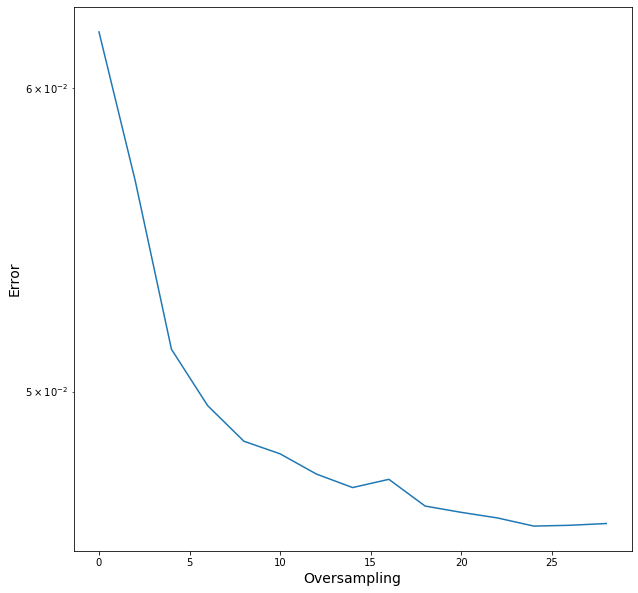

In [39]:
plt.figure(figsize=(10, 10))
plt.xlabel('Oversampling',fontsize = 14)
plt.ylabel('Error', fontsize = 14)
plt.semilogy(np.arange(0, len(res)*2,2),res)

**Замечание:** ```np.linalg.svd``` на этих размерах матриц и значенях рангов будет работать заметно медленнее (правда, с полностью контролируемой точностью), чем рандомизированный алгортм. Обратите также внимание, что если не указать опцию ```full_matrices=False``` в ```np.linalg.svd```, то на данном примере может также случиться переполнение по памяти. 

### c. Видео с переменным освещением 

Загрузим теперь более интересное видео, в котором со временем меняется освещение (можно, к примеру, представить, что встаёт солнце).

In [105]:
video2 = mpe.VideoFileClip("data/SVD_video_2.mp4")
video2.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [106]:
arr2 = video_to_array(video2)

image size: 60 x 80, 
number of frames: 2883


1. Аналогично пункту a.1) получите из трехмерного массива ```arr2``` двумерный массив ```M2``` размера ```nframes2 x (size_h * size_w)```. 

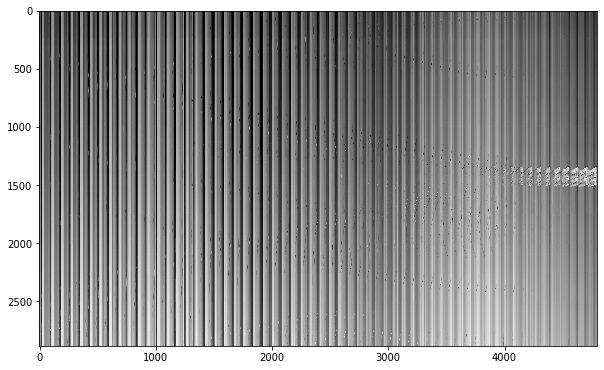

In [107]:
nframes2, size_w, size_h = arr2.shape
M2 = np.reshape(arr2, (nframes2, size_h * size_w))

plt.figure(figsize=(10, 10))
plt.imshow(M2, cmap='gray')

2.  Примените методы из пунктов a) и b) (то есть библиотечное полное SVD и рандомизированное SVD) для получения наилучшего приближения ранга 2 (чтобы также учесть изменение освещения) для матрицы `M2`.

In [92]:
M2_svd, rel_eps = trunc_svd(M2, 2)
M2_rand,rel_eps = rand_svd(M2, 2)

4.  Заполните пропуски в функции `M_to_video`, преобразующей матрицу типа ```M2``` обратно в видео.

In [126]:
def M_to_video(M, fps, size_w, size_h):
    nframes = M.shape[0]
    arr = np.reshape(M, (nframes, size_w, size_h))
    def make_frame(t):
        index = int(t * fps)
        frame = arr[index, :, :]
        frame = np.clip(frame, 0, 255)
        frame_rgb = frame[:, :, np.newaxis][:, :, [0,0,0]]
        return frame_rgb
    return mpe.VideoClip(make_frame, duration=nframes / fps)

Посмотрим, как выглядит предлагаемое приближение.

In [130]:
video2_svd = M_to_video(M2_svd - M2, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Для большей наглядности можете также запустить видео из пункта b) с более высоким разрешением.